In [1]:
# https://www.kaggle.com/onestar/kernel-xgboost-stacking
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard#score
import sys
import pandas as pd 
import matplotlib
import numpy as np
import scipy as sp
from IPython import display
import sklearn
import random, time, warnings

In [2]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier
import lightgbm as lgb

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [3]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [4]:
test_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal


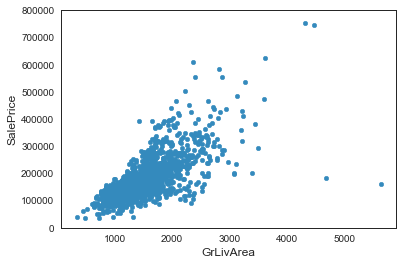

In [5]:
# 去除异常点
var = 'GrLivArea'
data = pd.concat([train_df['SalePrice'], train_df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [6]:
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 200000)].index)

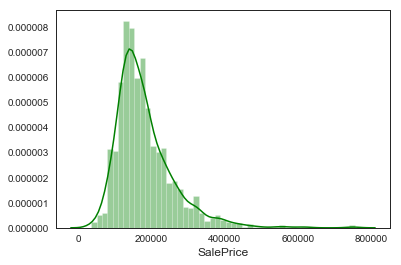

In [7]:
sns.distplot(train_df['SalePrice'], color='green')

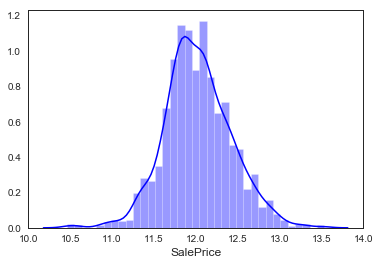

In [8]:
# 预测值倾斜，对数处理
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])
sns.distplot(train_df['SalePrice'], color='blue')

In [9]:
from sklearn.preprocessing import LabelEncoder
# categories = [i for i in train_df.columns if i not in cols]
# process columns, apply LabelEncoder to categorical features

numeric_features = list(train_df.dtypes[train_df.dtypes != 'object'].index)
numeric_features.remove('SalePrice')
print(len(numeric_features))
categories_features = list(train_df.dtypes[train_df.dtypes == 'object'].index)
print(len(categories_features))

37
43


In [10]:
for c in categories_features:
    lbl = LabelEncoder() 
    train_df[c] = lbl.fit_transform(list(train_df[c].values))
    test_df[c] = lbl.fit_transform(list(test_df[c].values))


# shape        
print ('Shape all_data: {}'.format(train_df.shape))
print ('Shape all_data: {}'.format(test_df.shape))

Shape all_data: (1458, 81)
Shape all_data: (1459, 80)


In [11]:
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,12.247699
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,12.109016
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,12.317171
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,11.849405
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,12.429220
5,6,50,3,85.0,14115,1,2,0,3,0,...,0,3,2,2,700,10,2009,8,4,11.870607
6,7,20,3,75.0,10084,1,2,3,3,0,...,0,3,4,4,0,8,2007,8,4,12.634606
7,8,60,3,NaN,10382,1,2,0,3,0,...,0,3,4,2,350,11,2009,8,4,12.206078
8,9,50,4,51.0,6120,1,2,3,3,0,...,0,3,4,4,0,4,2008,8,0,11.774528
9,10,190,3,50.0,7420,1,2,3,3,0,...,0,3,4,4,0,1,2008,8,4,11.678448


In [12]:
# 特征标准化
from scipy.special import boxcox1p
# skewed_features = list(skewness)
lam = 0.15
for feature in numeric_features:
    #all_data[feat] += 1
    train_df[feature] = boxcox1p(train_df[feature], lam)
    test_df[feature] = boxcox1p(test_df[feature], lam)
    
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
scaler.fit(train_df[numeric_features])
train_df[numeric_features] = scaler.transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

In [13]:
category_columns = train_df.dtypes[train_df.dtypes == 'object'].index

In [14]:
features_train = train_df.drop(['SalePrice'], axis=1)
labels_train = train_df['SalePrice']
features_test = test_df

In [15]:
train_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,-4.405917,0.375486,3,-0.072126,-0.166392,1,2,3,3,0,...,-0.06425,3,4,4,-0.187506,-1.882311,0.138655,8,4,12.247699
1,-4.199657,-1.094130,3,0.543719,0.080360,1,2,3,3,0,...,-0.06425,3,4,4,-0.187506,-0.318629,-0.614269,8,4,12.109016
2,-4.045515,0.375486,3,0.059944,0.393739,1,2,0,3,0,...,-0.06425,3,4,4,-0.187506,0.942391,0.138655,8,4,12.317171
3,-3.921288,0.604476,3,-0.304038,0.070169,1,2,0,3,0,...,-0.06425,3,4,4,-0.187506,-1.882311,-1.367510,8,0,11.849405
4,-3.816655,0.375486,3,0.691441,0.876324,1,2,0,3,0,...,-0.06425,3,4,4,-0.187506,1.628607,0.138655,8,4,12.429220
5,-3.725929,0.112019,3,0.727446,0.855165,1,2,0,3,0,...,-0.06425,3,2,2,4.994121,1.188558,0.891259,8,4,11.870607
6,-3.645624,-1.094130,3,0.350086,0.176749,1,2,3,3,0,...,-0.06425,3,4,4,-0.187506,0.674331,-0.614269,8,4,12.634606
7,-3.573444,0.375486,3,NaN,0.234157,1,2,0,3,0,...,-0.06425,3,4,2,4.178027,1.416385,0.891259,8,4,12.206078
8,-3.507786,0.112019,4,-0.765631,-0.769581,1,2,3,3,0,...,-0.06425,3,4,4,-0.187506,-0.745816,0.138655,8,0,11.774528
9,-3.447491,2.232091,3,-0.821031,-0.412955,1,2,3,3,0,...,-0.06425,3,4,4,-0.187506,-2.724411,0.138655,8,4,11.678448


In [16]:
features_train = pd.get_dummies(features_train)
features_test = pd.get_dummies(test_df)

missing_cols = set(features_train.columns) - set(features_test.columns)
for column in missing_cols:
    features_test[column] = 0
    
# 保证测试集columns的顺序同训练集columns相同，特别重要！！！！！！
features_test = features_test[features_train.columns]

In [17]:
features_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,-4.405917,0.375486,3,-0.072126,-0.166392,1,2,3,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,-1.882311,0.138655,8,4
1,-4.199657,-1.094130,3,0.543719,0.080360,1,2,3,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,-0.318629,-0.614269,8,4
2,-4.045515,0.375486,3,0.059944,0.393739,1,2,0,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,0.942391,0.138655,8,4
3,-3.921288,0.604476,3,-0.304038,0.070169,1,2,0,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,-1.882311,-1.367510,8,0
4,-3.816655,0.375486,3,0.691441,0.876324,1,2,0,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,1.628607,0.138655,8,4
5,-3.725929,0.112019,3,0.727446,0.855165,1,2,0,3,0,...,-0.291975,-0.06425,3,2,2,4.994121,1.188558,0.891259,8,4
6,-3.645624,-1.094130,3,0.350086,0.176749,1,2,3,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,0.674331,-0.614269,8,4
7,-3.573444,0.375486,3,NaN,0.234157,1,2,0,3,0,...,-0.291975,-0.06425,3,4,2,4.178027,1.416385,0.891259,8,4
8,-3.507786,0.112019,4,-0.765631,-0.769581,1,2,3,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,-0.745816,0.138655,8,0
9,-3.447491,2.232091,3,-0.821031,-0.412955,1,2,3,3,0,...,-0.291975,-0.06425,3,4,4,-0.187506,-2.724411,0.138655,8,4


In [18]:
X_train = features_train
y_train = labels_train

print (len(X_train))

1458


In [19]:
type(X_train)
type(y_train)

pandas.core.series.Series

In [20]:
train_data = lgb.Dataset(X_train, label=y_train)


In [23]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 5,
    'n_estimators': 720,
    'max_bin': 55,
    'bagging_freq': 5,
    'learning_rate': 0.05,
    'feature_fraction': 0.2319,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'feature_fraction_seed': 9,
    'bagging_seed': 9,
    'verbose': 0,
    'seed': 27,
    'min_data_in_leaf': 6,
    'min_sum_hessian_in_leaf': 11
}

print("starting training...")
t1 = time.time()
gbm = lgb.train(params, train_data)
t2 = time.time()
print("training in {:.4f}s".format(t2 - t1))
gbm.save_model("lightgbm.txt")

pred_y_lightbgm_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
sklearn.metrics.mean_squared_error(pred_y_lightbgm_train, y_train)  

starting training...
training in 0.3680s


0.005129626301492996

In [26]:
print("starting prediction")
t1 = time.time()
y_pred = gbm.predict(features_test, num_iteration=gbm.best_iteration)
t2 = time.time()
print("prediction in {:.2f}s".format(t2 - t1))
pre_y = np.expm1(y_pred)
result_y = pd.Series(pre_y)
result_id = pd.read_csv("./data/test.csv")["Id"]
result_df = pd.concat([result_id, result_y], axis=1)
result_df.columns = ["Id", "SalePrice"]
result_df.to_csv("result.csv", index=False)

starting prediction
prediction in 0.07s


In [91]:
# 模型：Xgboost
from sklearn.model_selection import GridSearchCV
import xgboost,time

best_reg_xgb = xgboost.XGBRegressor(learning_rate= 0.01, n_estimators = 5000, 
                    max_depth= 6, min_child_weight = 1.5, gamma = 0.01, 
                   subsample = 0.7, colsample_bytree = 0.6, 
                   seed = 27)

# modelfit(reg, X_train, y_train)
time1 = time.time()
best_reg_xgb.fit(X_train, y_train)
time2 = time.time()
pred_y_XGB = best_reg_xgb.predict(X_train)
time3 = time.time()

NameError: name 'X_train' is not defined

In [92]:
time3 - time2

NameError: name 'time3' is not defined

In [93]:
sklearn.metrics.mean_squared_error(pred_y_XGB,y_train)  

NameError: name 'pred_y_XGB' is not defined

In [94]:
X_test = features_test

NameError: name 'features_test' is not defined

In [95]:
pre_y =  best_reg_xgb.predict(X_test)

NameError: name 'X_test' is not defined

In [96]:
pre_y = np.expm1(pre_y)

NameError: name 'pre_y' is not defined

In [97]:
result_y = pd.Series(pre_y)

NameError: name 'pre_y' is not defined

In [98]:
result_id = pd.read_csv("./data/test.csv")["Id"]

FileNotFoundError: File b'./data/test.csv' does not exist

In [99]:
result_df = pd.concat([result_id, result_y], axis=1)
result_df.columns = ["Id", "SalePrice"]

NameError: name 'result_id' is not defined

In [100]:
result_df.to_csv("result.csv", index=False)

NameError: name 'result_df' is not defined

In [101]:
print("Hello")

Hello
